# Build genre dataset

This notebook documents the creation of the multi-genre dataset used in "Ascribing Historical Significance to Textual Similarity."

It begins with some exploration of the "subject" and "genre" fields in a deduplicated dataset of fiction in HathiTrust. The process of deduplication is more fully documented [in a different repository.](https://github.com/tedunderwood/noveltmmeta)

After surveying the landscape, I select certain subject and genre categories for the experiment. The sampling process is complicated, because I want to ensure that subsequent comparisons are able to compare non-overlapping sets.

Finally, HathiTrust metadata is used to define a rough measure of the social proximity between pairs of genres.

**Note to literary critics:** For the purpose of this experiment, I am *provisionally* borrowing the "subject" and "genre" categories librarians have used. A whole book could be written investigating the history of those categories, and arguing about their suitability. In other projects, I have used different genre definitions, borrowed from critics or bibliographers; in the future, I plan to use categories defined by the practice of book reviewers. The whole point of quantitative research on genre is that we don't have to be content with any particular set of categories, but are free to compare multiple perspectives.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import random, csv, math
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
meta = pd.read_csv('../../noveltmmeta/workmeta.tsv', sep = '\t', low_memory = False)

### Find the most common genres

The status of genre in library metadata is somewhat vexed. I won't have space to explore the topic fully here, but readers should be aware of a few pitfalls.

For instance, genre categories were not systematically applied to library records until quite late in the 20th century. So our dataset contains many records, especially earlier records, that lack genre categories altogether. Moreover, specific categories often displace general ones. Don't be surprised, for instance, that in a dataset with more than 100,000 novels, only 3301 bear an explicit designation "Novel."

The metadata used here was originally contained in MARC records, and then transformed using [a script written by Ted Underwood and Michael L. Black.](https://github.com/tedunderwood/genredistance/blob/master/select_data/scrape_marc.py) Generally the genre tags reported below are drawn from MARC fields 655 or 155, and were originally chosen by catalogers from a list of [Library of Congress Genre / Form Terms.](https://www.loc.gov/catdir/cpso/genre_form_faq.pdf) However, a few of the larger categories below reflect information in the MARC header field. Some of these will seem paradoxical: for instance, why does a dataset of fiction contain 41,743 records tagged "Not Fiction"? That tag just reflects the absence of an explicit "fiction" marker in the header.

In [3]:
allgenres = Counter()
for idx, row in meta.iterrows():
    genres = row.genres
    if pd.isnull(genres):
        continue
    else:
        genres = genres.split('|')
    
    for g in genres:
        allgenres[g] += 1

In [4]:
genres = allgenres.most_common()
genres[0:75]

[('Fiction', 76816),
 ('NotFiction', 41743),
 ('UnknownGenre', 5845),
 ('Bibliographies', 4424),
 ('Novel', 3301),
 ('Juvenile audience', 3071),
 ('Short stories', 1332),
 ('Domestic fiction', 1117),
 ('Love stories', 980),
 ('Historical fiction', 950),
 ('Psychological fiction', 902),
 ('ContainsBiogMaterial', 889),
 ('Detective and mystery stories', 691),
 ('Mystery fiction', 658),
 ('Autobiography', 459),
 ('Science fiction', 376),
 ('Suspense fiction', 371),
 ('Biography', 297),
 ('NotBiographical', 290),
 ('Bildungsromans', 277),
 ("Publishers' advertisements", 275),
 ('Humorous stories', 229),
 ('Bildungsromane', 219),
 ('Adventure stories', 210),
 ('War stories', 207),
 ('Biographical fiction', 197),
 ('Fantasy fiction', 185),
 ('Humorous fiction', 185),
 ('Political fiction', 177),
 ('Mixed', 166),
 ('Western stories', 149),
 ('Fantastic fiction', 134),
 ('Christian fiction', 124),
 ('Juvenile literature', 124),
 ('Satire', 100),
 ('Horror fiction', 99),
 ('Juvenile works', 94)

### Select groups of novels carrying specific genre tags

I select twenty genres, guided partly by an attempt to cover a range of different types of genres, and partly by a need to select genres with more than 100 examples in the dataset.

In some cases, I'm going to want to fold several different terms into a single category, so this is expressed as a dictionary where the key is a short term I plan to use, and the value is a set of terms I'll be fishing for in the dataset and equating to the key. In most cases, I think these decisions about synonymy are pretty transparent.

In [5]:
genre_categories = {'Novel': {'Novel'},
              'Juvenile': {'Juvenile audience'},
              'Short stories': {'Short stories'},
              'Domestic': {'Domestic fiction'},
              'Love': {'Love stories'},
              'Historical': {'Historical fiction'},
              'Psychological': {'Psychological fiction'},
              'Mystery': {'Detective and mystery stories', 'Mystery and detective fiction', 'Mystery fiction'},
              'Suspense': {'Suspense fiction'},
              'SF': {'Science fiction'},
              'Bildungsroman': {'Bildungsromans', 'Bildungsromane'},
              'Biographical': {'Biographical fiction'},
              'Humor': {'Humorous stories', 'Humorous fiction'},
              'Fantasy': {'Fantasy fiction', 'Fantastic fiction'},
              'Horror': {'Horror tales', 'Horror fiction', 'Occult fiction'},
              'Western': {'Western stories'},
              'Political': {'Political fiction'},
              'War': {'War stories'},
              'Adventure': {'Adventure stories', 'Adventure fiction'},
              'Christian': {'Christian fiction'}
             }

At this stage, we're not actually going to select specific examples of the genres. That needs to be done later, because I'm going to want to be able to guarantee that it's possible to compare genres and subjects to each other without overlap. So I need a complete list of genres, and a complete list of subjects, before selecting examples.

For right now, we simply iterate through the list of genre_categories and gather sets of matching volumes.

In [11]:
def hasgenre(row, genre2match):
    genres = row.genres
    date = row.inferreddate
    if pd.isnull(genres):
        return None
    elif pd.isnull(date) or int(date) < 1700 or int(date) > 2010:
        return None
    else:
        genres = genres.split('|')
        for g in genres:
            if g == genre2match:
                return row.docid
        return None

def gathergenre(genreset):
    global meta
    allmatches = set()
    for g in genreset:
        thisset = set(meta.apply(hasgenre, args = ([g]), axis = 1))
        thisset.remove(None)
        allmatches = allmatches.union(thisset)
    return allmatches     

We will store the sets of docids associated with each genre in ```category_dict```.

In [8]:
category_dict = dict()

for name, category in genre_categories.items(): 
    examples = gathergenre(category)
    category_dict[name] = examples

### most common subjects

Index terms contained in MARC fields 600-699 were counted as "subjects" if not specifically identified as "genre" terms or as "geographic" designations. Note that subject terms were added to MARC records several decades before genre terms came along. So in many 19c or early-20c records, things that we might consider genres are represented instead as subjects.

In [10]:
allsubjects = Counter()
for idx, row in meta.iterrows():
    genres = row.subjects
    if pd.isnull(genres):
        continue
    else:
        genres = genres.split('|')
    
    for g in genres:
        allsubjects[g] += 1

subjects = allsubjects.most_common()
subjects[0:100]

[('Fiction', 27190),
 ('History', 5469),
 ('Social life and customs', 2876),
 ('English fiction', 2436),
 ('Translations into English', 2024),
 ('United States', 1894),
 ('20th century', 1727),
 ('Juvenile fiction', 1325),
 ('American fiction', 1270),
 ('World War, 1939-1945', 1222),
 ('Folklore', 1163),
 ('England', 1138),
 ('Women', 1102),
 ('Description and travel', 994),
 ('Tales', 851),
 ('World War, 1914-1918', 793),
 ('19th century', 770),
 ('Short stories, American', 706),
 ('Great Britain', 684),
 ('Short stories', 647),
 ('Short stories, English', 642),
 ('Juvenile literature', 623),
 ('English literature', 578),
 ('Indians of North America', 574),
 ('New York (State)', 567),
 ('Civil War, 1861-1865', 554),
 ('Man-woman relationships', 550),
 ('African Americans', 541),
 ('American literature', 521),
 ('Gay men', 521),
 ('California', 511),
 ('France', 499),
 ('Fairy tales', 455),
 ('New York', 437),
 ('Lesbians', 436),
 ('Women authors', 424),
 ('Science fiction, American', 

In [40]:
subjects2find = {'Subj: Detective': {'Women detectives', 'Detective and mystery stories', 'Detective stories', 
                                     'Mystery and detective stories', 'Detective and mystery stories, French', 
                                     'Detective and mystery stories, New Zealand', 'Detective and mystery stories, Danish', 
                                     'Detective and mystery stories, Scottish', 'Detective and mystery stories, English', 
                                     'Detective and mystery stories, American'},
                 'Subj: Man-woman': {'Man-woman relationships', 'Marriage'}, 
                 'Subj: SF, Other': {'Science fiction, French', 'Science fiction, Canadian', 
                              'Science fiction, Polish', 'Science fiction, Australian', 
                              'Science fiction, Russian', 'Science fiction, English', 
                              'Science fiction'},
                 'Subj: SF, American': {'Science fiction, American'},
                 'Subj: Short stories, Other': {'Short stories, Icelandic', 'Short stories, Nepali',
                                                'Short stories, Serbian', 'Short stories, Turkish', 
                                                'Short stories, Ghanaian (English)', 'Short stories, Indic (English)',
                                                'Short stories in Russian, 1917-1945 - English texts', 
                                                'Short stories in French, 1900-1945 - English texts', 
                                                'Short stories, Ukrainian', 'Short stories, Caribbean (English)', 
                                                'Short stories, Sindhi', 'Short stories, Urdu', 'Short stories, Arabic', 
                                                'Short stories, Vietnamese', 'Short stories, Lithuanian', 
                                                'Short stories, African (English)', 'Short stories, Malaysian', 
                                                'Short stories, Australian', 'Short stories, Pakistani', 
                                                'Short stories, Irish', 'Short stories, South African (English)', 
                                                'Short stories, Bulgarian', 'Short stories, Panjabi', 
                                                'Short stories, Canadian', 'Short stories, New Zealand', 
                                                'Short stories, Norwegian', 'Short stories, Dutch', 
                                                'Short stories, Malay', 'Short stories, Tarascan', 
                                                'Short stories, English', 'Short stories, South African'},
                 'Subj: Short stories, American': {'Short stories, American'},
                 'Subj: Fairy tales': {'Fairy tales, American', 'Fairy tales, Scottish',
                                       'Fairy tales.', 'Fairy tales, Japanese', 
                                       'Fairy tales, German', 'Fairy tales, English', 
                                       'Fairy tales, French', 'Fairy tales'}, 
                 "Subj: Fantasy": {'Fantasy fiction, Scottish', 'Fantasy games', 'Fantasy fiction, Chinese',
                                   'Fantasy', 'Fantasy fiction, Yiddish', 'Fantasy fiction, French', 
                                   'Fantasy fiction', 'Fantasy fiction, Russian', 'Fantasy fiction, English',
                                   'Fantasy fiction, American', 'Fantasy fiction, Romanian'},
                 'Subj: Horror': {'Horror short stories in English, 1837-1945 - Anthologies', 
                                  'Horror tales, Singaporean', 'Horror & ghost stories', 'Horror tales',
                                  'Horror tales, Irish',  'Horror tales, American', 'Horror tales, Scottish',
                                  'Horror stories', 'Horror tales, Canadian', 'Horror tales, English',
                                  'Ghost stories', 'Ghosts'},
                 'Subj: History': {'History'},
                 'Subj: Humor': {'English wit and humor', 'Humor',
                          'American wit and humor', 'Humorous stories, American', 'Humorous stories'},
                 'Subj: Juvenile': {"Juvenile literature", "Juvenile fiction", "Children's stories",
                                   "Children's stories, American"}
                }

In [42]:
def hassubject(row, subj2match):
    ''' A little different from hasgenre, because it's looking
    for a phrase *in* a subject rather than attempting an exact
    match.
    '''
    subjects = row.subjects
    if pd.isnull(subjects) or pd.isnull(row.inferreddate):
        return None
    elif int(row.inferreddate) < 1700 or int(row.inferreddate) > 2010:
        return None
    else:
        subjects = subjects.split('|')
        for s in subjects:
            if s in subj2match:
                return row.docid
        
    return None

def gathersubject(subj):
    global meta
    thisset = set(meta.apply(hassubject, args = ([subj]), axis = 1))
    return thisset  

In [44]:
meta.reset_index(inplace = True)
for name, category in subjects2find.items():
    print(name)
    examples = gathersubject(category)
    examples.remove(None)
    category_dict[name] = examples

Subj: Man-woman
Subj: Detective
Subj: Short stories, Other
Subj: Fairy tales
Subj: Humor
Subj: Horror
Subj: Short stories, American
Subj: Juvenile
Subj: History
Subj: SF, Other
Subj: SF, American
Subj: Fantasy


In [45]:
# switch index for easier access

meta.set_index('docid', inplace = True)

In [46]:
with open('summary_of_available_genres.tsv', mode = 'w', encoding = 'utf-8') as f:
    writer = csv.DictWriter(f, delimiter = '\t', fieldnames = ['genre', 'numvols', 'meandate'])
    writer.writeheader()
    for catname, examples in category_dict.items():
        dates = meta.loc[examples, 'inferreddate']
        print(catname, '  |  ', len(examples), '  |  ', round(np.mean(dates), 2))
        outrow = dict()
        outrow['genre'] = catname
        outrow['numvols'] = len(examples)
        outrow['meandate'] = round(np.mean(dates), 2)
        writer.writerow(outrow)

Short stories   |   1332   |   1985.43
Subj: Humor   |   449   |   1922.93
Suspense   |   371   |   2003.47
Subj: Detective   |   650   |   1974.81
Domestic   |   1117   |   1992.33
Christian   |   124   |   1975.17
Horror   |   205   |   1989.45
Juvenile   |   3071   |   1894.53
Historical   |   950   |   1986.11
Subj: Juvenile   |   2228   |   1909.9
Fantasy   |   317   |   1992.12
Subj: SF, Other   |   331   |   1970.75
Subj: Man-woman   |   694   |   1972.54
Adventure   |   288   |   1981.65
Humor   |   406   |   1991.66
Love   |   980   |   1982.12
Novel   |   3301   |   1985.96
Western   |   149   |   1970.6
Political   |   177   |   1985.12
SF   |   375   |   1988.16
Subj: Horror   |   445   |   1975.04
Bildungsroman   |   490   |   1985.69
Subj: Short stories, American   |   706   |   1969.27
Subj: History   |   5090   |   1930.99
Subj: Fantasy   |   360   |   1978.74
Subj: Fairy tales   |   468   |   1923.91
Subj: Short stories, Other   |   1047   |   1974.07
War   |   207   |

So, we've got 32 categories: 20 genres and 12 subjects.

### Selecting examples of the categories

**Basic samples.** First, we simply select 102 random examples of each category. (We're going to use 100-text samples, but it's wise to leave a little extra room in case one text turns out to be defective / missing.)

**Intersectional samples.** But we also want to be able to ensure non-overlapping comparisons if needed. So we also compare each category to all the others, and where there are intersections, we create extra categories like

    Horror-Not-Humor

With enough extra volumes to ensure non-overlap.

**B samples.**

In genres where we have enough examples to go around, we also create a second "B sample," to permit self-comparison. These have to be non-overlapping with the A sample, but we don't do the whole intersectional song and dance for the B samples.

In [47]:
genredist = dict()

def get_pure_examples(catname1, catname2, catset1, catset2, category_dict, overlaplen):
    only1 = category_dict[catname1] - category_dict[catname2]
    # Let's sample from examples of category 1 known not to be in
    # category 2
    
    only1 = only1 - catset1
    # Because these are supposed to be additional examples, not ones
    # already in the category
    
    onenottwo = random.sample(only1, overlaplen)
    return onenottwo

# first, we select the basic genre samples

for catname, examples in category_dict.items():
    
    chosen = random.sample(examples, 102)
    genredist[catname] = set(chosen)
        
print()
print('Basic samples selected.')
print()
print('Intersectional samples:')
print('-----------------------')

# then create special intersectional categories
# to permit non-overlapping comparisons

toadd = dict()
for g1, gset1 in genredist.items():
    for g2, gset2 in genredist.items():
        if g1 == g2:
            continue
        
        overlap = len(gset1.intersection(gset2))
        if overlap > 0:
            print(g1, g2, overlap)
            only1 = get_pure_examples(g1, g2, gset1, gset2, category_dict, overlap)
            name1not2 = g1 + '-Not-' + g2
            toadd[name1not2] = only1
            
            only2 = get_pure_examples(g2, g1, gset2, gset1, category_dict, overlap)
            name2not1 = g2 + '-Not-' + g1
            toadd[name2not1] = only2

for key, value in toadd.items():
    genredist[key] = value
    
print()            
print('Intersectional samples selected.')
print()
print('B samples:')
print('----------')
# Then we select "B" samples in cases where there are enough instances
# to make this practical.

for catname, examples in category_dict.items():
    
    chosen = genredist[catname]
    
    if len(examples) > 300:
        remainder = examples - set(chosen)
        nameB = catname + ' B'
        chosenB = random.sample(remainder, 102)
        genredist[nameB] = chosenB
        print(nameB)


Basic samples selected.

Intersectional samples:
-----------------------
Short stories Fantasy 1
Short stories Subj: SF, Other 1
Short stories Subj: Man-woman 1
Short stories Subj: Horror 3
Short stories Subj: Short stories, American 1
Short stories Subj: Short stories, Other 1
Short stories Subj: SF, American 2
Short stories Subj: Fantasy 1
Christian Domestic 1
Christian Fantasy 5
Christian Humor 1
Christian Biographical 5
Christian SF 1
Christian Psychological 1
Suspense Political 1
Suspense Novel 1
Suspense Bildungsroman 1
Subj: Detective Horror 1
Subj: Detective Juvenile 1
Subj: Detective Historical 1
Subj: Detective Subj: Juvenile 1
Subj: Detective Adventure 1
Subj: Detective Mystery 1
Domestic Christian 1
Domestic Subj: Man-woman 1
Domestic Adventure 1
Domestic Novel 1
Domestic Love 1
Domestic Bildungsroman 1
Domestic War 1
Domestic Psychological 2
Subj: Humor Subj: SF, Other 1
Horror Subj: Detective 1
Horror Fantasy 2
Horror Subj: SF, Other 1
Horror Western 1
Horror Love 1
Horr

In [48]:
allvols = set()
for name, genreset in genredist.items():
    allvols = allvols.union(genreset)
print(len(allvols))

5585


### Exploratory analysis of selected volumes

Just to get a sense of what we're looking at.

The cell immediately below also importantly creates the dictionary ```genresfordocs```, which will be used a lot below. This is a dict where each key is a volume ID and the value is a set of genre tags possessed by the volume.

In [49]:
# Now let's get a sense of how these volumes are distributed on the timeline
genresfordocs = dict()
for genrename, docsingenre in genredist.items():
    for docid in docsingenre:
        if docid not in genresfordocs:
            genresfordocs[docid] = set()
        genresfordocs[docid].add(genrename)

datedist = Counter()
datebygenre = dict()
allgenrenames = set()

for docid, genreset in genresfordocs.items():
    date = int(meta.loc[docid, 'inferreddate'])
    datedist[date] += 1
    for g in genreset:
        allgenrenames.add(g)
        if g not in datebygenre:
            datebygenre[g] = Counter()
        datebygenre[g][date] += 1

print(len(datedist))
print(sum(datedist.values()))
print()

maxforyear = dict()
for d in datedist.keys():
    maximum = 0
    for g in allgenrenames:
        if datebygenre[g][d] > maximum:
            maximum = datebygenre[g][d]
    maxforyear[d] = maximum
print(sum(maxforyear.values()))  

211
5585

690


#### maximum number of vols in a year

This is not all the volumes, but just the maximum in any single genre. It's an important figure because we're going to use this to guarantee that our random datasets have enough volumes to create a date-matching contrast set for any genre.

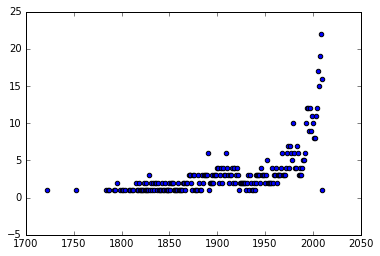

In [50]:
from matplotlib import pyplot as plt
%matplotlib inline

x = []
y = []
for date, count in maxforyear.items():
    x.append(date)
    y.append(count)

plt.scatter(x, y)

#### all vols in a year

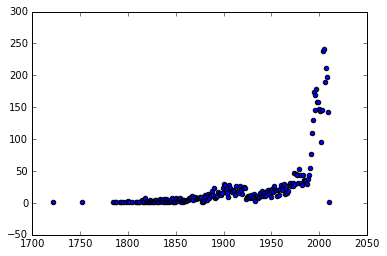

In [51]:
x = []
y = []
for date, count in datedist.items():
    x.append(date)
    y.append(count)

plt.scatter(x, y)

2009


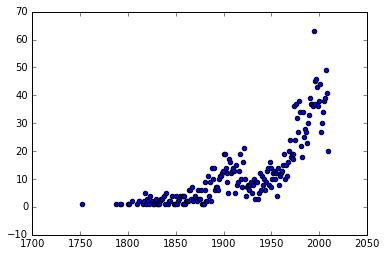

In [52]:
# now only for "subjects"

subjdatedist = Counter()

for docid, genreset in genresfordocs.items():
    date = int(meta.loc[docid, 'inferreddate'])
    for g in genreset:
        if g.startswith('Subj:'):
            subjdatedist[date] += 1
            break

x = []
y = []
for date, count in subjdatedist.items():
    x.append(date)
    y.append(count)

plt.scatter(x, y)
print(np.amax(list(subjdatedist.keys())))

### Gather random contrast sets

We gather two contrast sets. (Some predictive modeling we do is going to require that a model trained on contrast set A be applied to a non-overlapping set B.)

Note however that we do *not* ensure the sets are non-overlapping with our genre sets. That would create a selection bias. Later on, we can select *within* randomA or randomB to get a negative set that matches a given positive set by date and doesn't overlap with it.

In [53]:
# let's get random fiction that roughly matches that date distribution

chosenrandomA = []
chosenrandomB = []

for date, count in maxforyear.items():
    candidates = meta.loc[meta.inferreddate == date, : ]
    eligible_indices = candidates.index.tolist()
    choiceA = random.sample(eligible_indices, count)
    eligible_indices = list(set(eligible_indices) - set(choiceA))
    if len(eligible_indices) < count:
        print("error, running dry")
        break
    else:
        choiceB = random.sample(eligible_indices, count)
    
    chosenrandomA.extend(choiceA)
    chosenrandomB.extend(choiceB)
        
print(len(chosenrandomA))

690


In [54]:
# integrate the random choices into genresfordocs:
print(len(genresfordocs))

for docid in chosenrandomA:
    if docid not in genresfordocs:
        genresfordocs[docid] = {'randomA'}
    else:
        genresfordocs[docid].add('randomA')

for docid in chosenrandomB:
    if docid not in genresfordocs:
        genresfordocs[docid] = {'randomB'}
    else:
        genresfordocs[docid].add('randomB')

print(len(genresfordocs))

5585
6872


Write the sizes and mean dates of genres as selected. We might need this later.

In [55]:
with open('../metadata/selected_genres.tsv', mode = 'w', encoding = 'utf-8') as f:
    writer = csv.DictWriter(f, delimiter = '\t', fieldnames = ['genre', 'numvols', 'meandate'])
    writer.writeheader()
    for genrename, examples in genredist.items():
        dates = meta.loc[examples, 'inferreddate']
        outrow = dict()
        outrow['genre'] = genrename
        outrow['numvols'] = len(examples)
        outrow['meandate'] = round(np.mean(dates), 2)
        writer.writerow(outrow)
    examples = chosenrandomA
    dates = meta.loc[examples, 'inferreddate']
    outrow = dict()
    outrow['genre'] = 'randomA'
    outrow['numvols'] = len(examples)
    outrow['meandate'] = round(np.mean(dates), 2)
    writer.writerow(outrow)
    examples = chosenrandomB
    dates = meta.loc[examples, 'inferreddate']
    outrow = dict()
    outrow['genre'] = 'randomB'
    outrow['numvols'] = len(examples)
    outrow['meandate'] = round(np.mean(dates), 2)
    writer.writerow(outrow)
    
    

### Actually write the main metadata to disk.

In [56]:
# okay, now let's write the thing

allchosen = list(genresfordocs.keys())

chosendf = meta.loc[allchosen, ['author', 'shorttitle', 'enumcron', 'inferreddate', 'genres', 'subjects', 'allcopiesofwork']]

In [57]:
chosendf.shape

(6872, 7)

In [58]:
# Create a column for the genre tags.

def mygenres(idx):
    global genresfordocs
    if idx not in genresfordocs:
        print("ERROR")
        return float('nan')
    else:
        return '|'.join(genresfordocs[idx])

chosendf = chosendf.assign(tags = chosendf.index.map(mygenres))

In [59]:
chosendf.rename(index=str, columns={"inferreddate": "firstpub"}, inplace = True)

# No, these are not really dates of first publication. But my modeling code has
# evolved to use 'firstpub' as a default term and I don't want to fiddle with it.

In [60]:
chosendf.head()

,author,shorttitle,enumcron,firstpub,genres,subjects,allcopiesofwork,tags
docid,,,,,,,,
mdp.39015041290811,"MacLean, Rory",The oatmeal ark : from the Western Isles to a ...,NaN,1997,Fiction|Fantastic fiction,Fiction|Voyages and travels,1,Fantasy
uc2.ark+=13960=t9h41km75,"Stephens, C. A. (Charles Asbury)",A busy year at the old squire's,NaN,1922,NotFiction,NaN,2,randomB
uc1.$b299829,"Clewes, Winston","Sweet river in the morning, a novel",NaN,1946,Fiction,NaN,1,randomA
mdp.39015069154246,"Bouldrey, Brian","Love, the magician",NaN,2000,Novel|Psychological fiction,Fiction|Gay men,1,Psychological B
uiuo.ark+=13960=t6j10p77j,"Opie, Amelia","Temper ; or, Domestic scenes",v.3,1812,NaN,NaN,3,randomA


In [61]:
chosendf.to_csv('../metadata/genremeta.csv')

### Measures of social proximity

We can also use metadata to generate estimates of the *social* proximity of two genres. I'm going to do this by measuring the pointwise mutual information of their co-association with volumes.
    
    log(p(x, y)/p(x)p(y)).
    
Where p(x) is, for instance, the probability that a volume is labeled "Humor," p(y) the probability that a volume is labeled "Horror," and p(x, y) the probability that the same volume is labeled "Humor" and "Horror."

However, we also want to acknowledge that the probability of two categories overlapping declines when they have largely disjoint chronological distributions. The "subjects" we're considering are, by and large, assigned earlier than the "genres," and they will tend not to be co-associated for that reason.

So I'm proposing a conditional version of PMI, where p(x), p(y), and p(x, y) are all measured *within* a sample of volumes defined by the chronological distribution of x and y. This will give a boost to PMI in cases where the chronological distributions are spread out over a wide swath of the timeline, because p(x), p(y), and p(x, y) are all lowered by the same amount, but that amount gets basically squared in the denominator: ```p(x)p(y)```. At least that's how I think it will work! It conforms intuitively to the notion that coincidence of x and y is less likely when the events are rare within the frame of reference (of say 100 years), and more likely when "the relevant framework" is just (say) 30 years where the genres substantially coincide.

#### Priors

It also makes sense to define certain priors about the relationships of genres. Catalogers may not specify the subject "humor" if they've already put "humor" in the genre field. But we can see that those tags are substantially equivalent.

I don't want to hard-code a fixed value, so I have expressed this as a strong prior that "bends" evidence in its direction. That also permits the possibility that the subject "humor" may actually mean something different from the genre "humor," if only because the tags were assigned in different periods. This is also why I have expressed the expected similarity as 80% (see below) rather than a firm postulate of identity.

Note that this is not a rigorous Bayesian set up where every measure of social proximity is going to be calculated ```posterior = prior x likelihood.``` Most of the PMI values will be calculated directly from the evidence. The priors are just an ad-hoc fix for particular pairs of genres that we expect to be very similar.

In [117]:
# The list of priors

priors = {'Subj: Horror': {'Horror': 0.8},
          'Subj: Humor': {'Humor': 0.8},
          'Subj: History': {'Historical': 0.8},
          'Subj: Man-woman': {'Love': 0.6}, 
          'Subj: Short stories, American': {'Short stories': 0.8, 'Subj: Short stories, Other': 0.8},
          'Subj: Short stories, Other': {'Short stories': 0.8, 'Subj: Short stories, American': 0.8},
          'Subj: SF, American': {'SF': 0.8, 'Subj: SF, Other' : 0.8},
          'Subj: SF, Other': {'SF': 0.8, 'Subj: SF, American': 0.8},
          'Subj: Fantasy': {'Fantasy': 0.8}, 
          'Subj: Juvenile': {'Juvenile': 0.8},
          'Subject: Detective': {'Mystery': 0.8}
         }

# Let's turn that into a symmetric dictionary where A -> B
# also implies B -> A
tuplelist = []
for key1, matches in priors.items():
    for match, realnumber in matches.items():
        tuplelist.append((key1, match, realnumber))
        
for t in tuplelist:
    key1, match, realnumber = t
    if match not in priors:
        priors[match] = dict()
    priors[match][key1] = realnumber
    
priors

{'Fantasy': {'Subj: Fantasy': 0.8},
 'Historical': {'Subj: History': 0.8},
 'Horror': {'Subj: Horror': 0.8},
 'Humor': {'Subj: Humor': 0.8},
 'Juvenile': {'Subj: Juvenile': 0.8},
 'Love': {'Subj: Man-woman': 0.6},
 'Mystery': {'Subject: Detective': 0.8},
 'SF': {'Subj: SF, American': 0.8, 'Subj: SF, Other': 0.8},
 'Short stories': {'Subj: Short stories, American': 0.8,
  'Subj: Short stories, Other': 0.8},
 'Subj: Fantasy': {'Fantasy': 0.8},
 'Subj: History': {'Historical': 0.8},
 'Subj: Horror': {'Horror': 0.8},
 'Subj: Humor': {'Humor': 0.8},
 'Subj: Juvenile': {'Juvenile': 0.8},
 'Subj: Man-woman': {'Love': 0.6},
 'Subj: SF, American': {'SF': 0.8, 'Subj: SF, Other': 0.8},
 'Subj: SF, Other': {'SF': 0.8, 'Subj: SF, American': 0.8},
 'Subj: Short stories, American': {'Short stories': 0.8,
  'Subj: Short stories, Other': 0.8},
 'Subj: Short stories, Other': {'Short stories': 0.8,
  'Subj: Short stories, American': 0.8},
 'Subject: Detective': {'Mystery': 0.8}}

In [118]:
def sample_bag_of_years(bag_of_years, yeardict):
    sample = []
    errors = 0
    for i in range(25000):
        b = random.choice(bag_of_years)
        if pd.isnull(b):
            errors += 1
        else:
            vol = random.choice(yeardict[b])
            sample.append(vol)
    return sample

def labelprob(sample, label, theprior, otherlabel):
    global category_dict
    count = 0
    bothcount = 0
    
    for s in sample:
        if s in category_dict[label]:
            count += 1
            bothcount += 1
        elif theprior > 0 and theprior < 1 and s in category_dict[otherlabel]:
            bothcount += 1
    
    if theprior > 0 and theprior < 1:
        count = (count + (bothcount * theprior)) / 2
        
    # the addition of 0.1 is Laplacian smoothing
    return (count + 0.1) / len(sample)

def labelxyprob(sample, labelx, labely, theprior):
    global category_dict
    count = 0
    candidates = 0
    for s in sample:
        if s in category_dict[labelx] and s in category_dict[labely]:
            count += 1
            candidates += 1
        elif s in category_dict[labelx]:
            candidates += 1
        elif s in category_dict[labely]:
            candidates += 1
    
    if theprior > 0 and theprior < 1:
        priorcount = candidates * theprior
        count = (count + priorcount) / 2
        
    # This prior is informative only in a small number of cases
    # where we expect a strong match, and know that the data
    # will underrepresent the match, because of the difference
    # of "subjects" and "genres."
    
    # Most comparisons will have
    # no prior, because we don't actually let theprior == 0
    # drag a comparison down below observed evidence.
        
    # the addition of 0.1 is Laplacian smoothing
    return (count + 0.1) / len(sample)

yeardict = dict()
for yr in range(1700, 2100):
    yeardict[yr] = meta.index[meta['inferreddate'] == yr].tolist()

pmidict = dict()

for name1, ex1 in category_dict.items():
    print(name1)
    for name2, ex2 in category_dict.items():
        
        if name1 not in pmidict:
            pmidict[name1] = dict()
            
        if name2 in pmidict and name1 in pmidict[name2]:
            pmidict[name1][name2] = pmidict[name2][name1]
            
        else:
            bag1 = meta.loc[ex1, 'inferreddate']
            bag2 = meta.loc[ex2, 'inferreddate']
            jointbag = list(bag1) + list(bag2)
            sample_of_docids = sample_bag_of_years(jointbag, yeardict)
            
            if name1 == name2:
                theprior = 1
                # There is no meaningful definition of PMI where two categories
                # perfectly coincide. We're going to improvise, in a way that
                # allows small categories to be more self-similar than
                # large ones.
                
            elif name1 in priors and name2 in priors[name1]:
                theprior = priors[name1][name2]
            else:
                theprior = 0
            
            
            prob2 = labelprob(sample_of_docids, name2, theprior, name1)
            prob1 = labelprob(sample_of_docids, name1, theprior, name2) 
            jointprob = labelxyprob(sample_of_docids, name1, name2, theprior)
            pmidict[name1][name2] = math.log(jointprob / (prob1 * prob2))
    

Short stories
Subj: Humor
Suspense
Subj: Detective
Domestic
Christian
Horror
Juvenile
Historical
Subj: Juvenile
Fantasy
Subj: SF, Other
Subj: Man-woman
Adventure
Humor
Love
Novel
Western
Political
SF
Subj: Horror
Bildungsroman
Subj: Short stories, American
Subj: History
Subj: Fantasy
Subj: Fairy tales
Subj: Short stories, Other
War
Psychological
Subj: SF, American
Biographical
Mystery


In [119]:
pmidf = pd.DataFrame(pmidict)

In [120]:
for idx in pmidf.index:
    maximum = max(pmidf.loc[idx, : ])
    if maximum > pmidf.loc[idx, idx]:
        print(idx, maximum)
        pmidf.loc[idx, idx] = maximum

Humor 4.0896471879


In [132]:
pmidf['Adventure']['Mystery']

0.094113113857693637

In [121]:
pmidf

,Adventure,Bildungsroman,Biographical,Christian,Domestic,Fantasy,Historical,Horror,Humor,Juvenile,...,Subj: Humor,Subj: Juvenile,Subj: Man-woman,"Subj: SF, American","Subj: SF, Other","Subj: Short stories, American","Subj: Short stories, Other",Suspense,War,Western
Adventure,4.279903,0.435610,0.343080,0.221690,0.305965,0.588636,1.379508,-3.243798,1.227815,1.130951,...,-2.400227,0.936398,0.441526,-2.845089,1.117171,-2.666464,-3.010117,-1.688237,0.795667,-2.159260
Bildungsroman,0.435610,4.053356,-3.165622,1.131953,1.720973,-0.694249,1.093455,-0.328167,1.701955,-3.335126,...,-2.928306,-3.135787,0.821285,-3.273126,-2.619720,-3.338657,-3.604928,-0.693552,2.265967,0.977699
Biographical,0.343080,-3.165622,4.916599,3.110273,0.009942,-2.894851,2.114180,-2.517358,-2.962145,-1.474224,...,-1.756554,-1.443649,-2.944366,-2.256043,-1.651594,-2.421566,-2.428072,-3.985702,1.844265,2.425606
Christian,0.221690,1.131953,3.110273,5.416200,1.049163,2.156130,1.000321,-2.123703,-2.363184,-1.696563,...,-1.407832,-1.033527,1.248363,-1.256016,-1.016478,-1.682466,-1.673172,-0.660272,-1.463414,-0.668447
Domestic,0.305965,1.720973,0.009942,1.049163,3.189220,-2.378864,1.054664,-1.374636,0.861812,-4.720872,...,-3.603519,-4.332381,1.263024,-3.971152,-3.427581,-1.001827,-4.536183,-0.428196,0.661536,0.218978
Fantasy,0.588636,-0.694249,-2.894851,2.156130,-2.378864,4.234711,0.909377,2.179593,0.245513,-0.639921,...,-2.528873,-2.494904,0.011914,-0.423531,0.611025,-3.223219,-3.228188,0.249198,-0.496345,-2.330399
Historical,1.379508,1.093455,2.114180,1.000321,1.054664,0.909377,3.489242,0.085551,-1.092102,-1.965720,...,-3.201279,-3.927214,0.290489,-3.801247,-3.134623,-4.045185,-4.163451,0.117043,2.682408,1.667594
Horror,-3.243798,-0.328167,-2.517358,-2.123703,-1.374636,2.179593,0.085551,4.612799,-3.410408,-2.254403,...,-2.001259,-1.756085,-3.296209,-2.493054,-1.911615,-2.608324,-0.432951,0.245167,-2.487540,0.969952
Humor,1.227815,1.701955,-2.962145,-2.363184,0.861812,0.245513,-1.092102,-3.410408,4.089647,-0.521751,...,4.089647,-0.587908,1.357892,-2.979538,-2.398768,-3.169652,-3.294340,-0.207172,-2.925803,-2.301749
Juvenile,1.130951,-3.335126,-1.474224,-1.696563,-4.720872,-0.639921,-1.965720,-2.254403,-0.521751,3.087760,...,-3.941342,3.026684,-1.469373,-2.882120,-2.457515,-3.453150,-3.962527,-3.733282,0.312924,-1.991889


In [133]:
pmidf.to_csv('../socialmeasures/pmidf.csv', index_label = 'index')